In [1]:
import numpy as np
import torch
from PQC import getHaar
import matplotlib.pyplot as plt

In [2]:
class QuantumState:
    def __init__(self,num=4):
        self.num = num
        self.state = np.zeros((2**num,2))
        self.state[0,0]=1
        self.state = torch.FloatTensor(self.state)
        self.state = torch.view_as_complex(self.state)
        # self.state.requires_grad_(True)
        # print(self.state)
    def SingleRX(self,theta):
        cost = torch.cos(theta/2)
        mjsint = -1j*torch.sin(theta/2)
        px = torch.cat((cost,mjsint,mjsint,cost))
        px = px.view((2,2))
        # print(px)
        return px
    def SingleRZ(self,theta):
        mexp = torch.exp(-0.5j*theta)
        pexp = torch.exp(0.5j*theta)
        zero = torch.zeros(1,)
        pz = torch.cat((mexp,zero,zero,pexp))
        return pz
    def SingleToMultiQubit(self,pos,p):
        eye = torch.eye(2)
        if pos==0:
            out = p
        else:
            out = eye
            for i in range(1,pos):
                out = torch.kron(out,eye)
            out = torch.kron(out,p)
        for i in range(pos+1,self.num):
            out = torch.kron(out,eye)
        out = torch.reshape(out,(2**self.num,-1))
        self.state = torch.matmul(out,self.state)
    def RX(self,pos,theta):
        self.SingleToMultiQubit(pos,self.SingleRX(theta))
    def RZ(self,pos,theta):
        self.SingleToMultiQubit(pos,self.SingleRZ(theta))

In [3]:
q = QuantumState(2)
print(q.state)

tensor([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])


In [4]:
param = torch.randn(1,requires_grad=True)
print(param)
q.RZ(1,param)
print(q.state)
output = q.state.sum()
print(output)
output.backward()
param.grad

tensor([-0.0139], requires_grad=True)
tensor([1.0000+0.0070j, 0.0000+0.0000j, 0.0000+0.0000j, 1.0000+0.0070j],
       grad_fn=<MvBackward>)
tensor(2.0000+0.0139j, grad_fn=<SumBackward0>)


tensor([0.0070])

In [3]:
def LayerInitializer(Layer,params):
    Layer.requires_grad_(False)
    for i in range(2):  #4
        Layer.weight[i] = params[2*i:2*(i+1)]
    for i in range(2):
        Layer.bias[i] = params[4+i]
def getPQCvector(params):
    Layer1 = torch.nn.Linear(2,2)
    LayerInitializer(Layer1,params[:6])
    Layer2 = torch.nn.Linear(2,2)
    LayerInitializer(Layer2,params[6:])
    input = torch.rand(2,)
    h1 = Layer1(input)
    a1 = torch.nn.Tanh()(h1)
    theta = Layer2(a1)
    # print("th",theta)
    q = QuantumState(2)
    q.RX(0,theta[0].view(1,))
    q.RX(1,theta[1].view(1,))
    v = q.state.view(-1,1)
    return v
def Loss(params, verbose=0, bins=250, num=10000):
    Fidelity = None
    # print(Fidelity)
    haar_hist = torch.from_numpy(getHaar(reps=num,bins=bins,qubits=2))
    # params = torch.randn(2,requires_grad=True)
    for i in range(num):
        v1 = getPQCvector(params)
        v2 = getPQCvector(params)
        F = torch.abs(torch.matmul(torch.conj(torch.transpose(v1,0,1)),v2))**2
        if Fidelity is None:
            Fidelity = F.view(1,)
        else:
            Fidelity = torch.cat((Fidelity,F.view(1,)),-1)
    print(Fidelity)
    hist = torch.histc(Fidelity,min=0,max=1,bins=bins)/num
    if verbose == 1:
        x = np.linspace(0,1,bins)
        plt.plot(x,torch.detach(hist))
        plt.plot(x,torch.detach(haar_hist))
        plt.figure()
    # kl = torch.kl_div(hist.log(),haar_hist,reduction=1)
    p = hist*(hist/haar_hist).log()
    p[p!=p]=0
    return p.sum()

In [8]:
params = torch.zeros(12,)
params[0] = 1
params[3] = 1
params[6] = 2*np.pi
params[9] = 2*np.pi
temp = torch.empty(12,)
grad = torch.empty(12,)
epoch = 100
eps = 0.01
eta = 0.001
# print(Loss(params))
for i in range(epoch):
    loss_before = Loss(params,verbose=0)
    temp = params
    for j in range(params.size()[0]):
        temp[j] += eps
        grad[j] = (Loss(temp) - loss_before)/eps
        temp[j] -= eps
        # print(torch.abs(grad[j]))
    params -= eta * grad
    print("params: ",params)
    print(loss_before)


)
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tensor([nan, nan])
th tenso

KeyboardInterrupt: 

In [7]:
m = torch.nn.Linear(2,2,bias=True)
m.requires_grad_(False)
input = torch.randn(1,2)
output = m(input)
print(output.size())
print(m.weight[0])
print(m.bias)
m.weight[0,0]=1

torch.Size([1, 2])
tensor([-0.5320, -0.2468])
Parameter containing:
tensor([ 0.3516, -0.6015])


In [34]:
# m.weight[0,0]=1
m = torch.nn.Linear(2,2,bias=True)
m.requires_grad_(False)

print(list(m.parameters()))

for p in m.parameters():
    print(p)
    print(p[0].weight)
print(list(m.parameters()))

[Parameter containing:
tensor([[-0.0934, -0.4060],
        [-0.5118, -0.1921]]), Parameter containing:
tensor([ 0.2878, -0.5292])]
Parameter containing:
tensor([[-0.0934, -0.4060],
        [-0.5118, -0.1921]])


AttributeError: 'Tensor' object has no attribute 'weight'

In [92]:
Layer1 = torch.nn.Linear(2,2)
Layer1.requires_grad_(False)
input = torch.rand(2,)
h1 = Layer1(input)
print(h1)
a=torch.nn.ReLU()(h1)
print(a.tolist()[1])

tensor([-0.5192,  0.6990])
0.6990397572517395


In [14]:
params = torch.randn(12,)
Layer1 = torch.nn.Linear(2,2)
Layer1.requires_grad_(False)
Layer1.weight[0] = params[:2]
Layer1.weight[1] = params[2:4]
print(Layer1)
print(Layer1.weight[0])
print(Layer1.bias[0])
print(params[4:6])
Layer1.bias = params[4:6]


Linear(in_features=2, out_features=2, bias=True)
tensor([0.3575, 2.8662])
tensor(0.1008)
tensor([0.3506, 1.5560])


TypeError: cannot assign 'torch.FloatTensor' as parameter 'bias' (torch.nn.Parameter or None expected)


th tensor([0.1796, 0.7775])
th tensor([0.5044, 0.2162])
th tensor([0.3826, 0.7761])
th tensor([0.3314, 0.8207])
th tensor([0.3934, 0.7126])
th tensor([0.2050, 0.8053])
th tensor([0.4576, 0.5231])
th tensor([0.5032, 0.2277])
th tensor([0.5026, 0.2299])
th tensor([0.4667, 0.4473])
th tensor([0.4453, 0.5951])
th tensor([0.4854, 0.3618])
th tensor([0.3119, 0.8170])
th tensor([0.3349, 0.7815])
th tensor([0.4827, 0.3403])
th tensor([0.4369, 0.5720])
th tensor([0.4882, 0.3319])
th tensor([0.2272, 0.8185])
th tensor([0.2345, 0.8227])
th tensor([0.5112, 0.1597])
th tensor([0.4947, 0.2718])
th tensor([0.3886, 0.7130])
th tensor([0.3612, 0.7548])
th tensor([0.4829, 0.3473])
th tensor([0.2978, 0.8189])
th tensor([0.5075, 0.1881])
th tensor([0.5012, 0.2369])
th tensor([0.4924, 0.3007])
th tensor([0.4852, 0.3515])
th tensor([0.4469, 0.5225])
th tensor([0.4836, 0.3709])
th tensor([0.4217, 0.6085])
th tensor([0.2051, 0.8038])
th tensor([0.4422, 0.5270])
th tensor([0.4468, 0.5586])
th tensor([0.4452, 

tensor(10.3246, dtype=torch.float64)

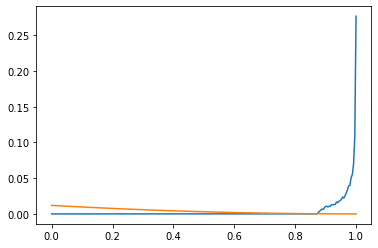

<Figure size 432x288 with 0 Axes>

In [5]:
params = torch.randn(12,)
print(params)
Loss(params,verbose=1)